In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install jupyter_bbox_widget

In [ ]:
import os
import cv2
import torch
import numpy as np
import supervision as sv
from PIL import Image

from detic import Detic
from detic.inference import load_classifier

In [ ]:
torch.no_grad().__enter__()

In [ ]:
import supervision as sv
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

In [ ]:
# helper function that loads an image before adding it to the widget
import io
import base64

def encode_image(im):
    buf = io.BytesIO()
    Image.fromarray(im).save(buf, format='PNG')
    encoded = str(base64.b64encode(buf.getvalue()), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
model = Detic()

In [ ]:
# f = 'measurecup.png'
# f = 'coffee-tools-2.png'
# f = 'tortilla-quesadilla.png'
f = os.path.expanduser('/datasets/rolled-tortillas-office.png')
rgb=np.array(Image.open(f))[:,:,:3]
bgr = rgb[:,:,::-1]
Image.fromarray(rgb)

In [ ]:
from jupyter_bbox_widget import BBoxWidget
widget = BBoxWidget()
widget.image = encode_image(rgb)
widget

In [ ]:
gt_boxes = torch.Tensor([
    [d['x'], d['y'], d['width'], d['height']]
    for d in widget.bboxes
])
gt_boxes[:, 2:] += gt_boxes[:, :2]
gt_boxes

In [ ]:
query = model.build_query(rgb)

In [ ]:
instances = query.predict(gt_boxes.cuda())['instances']
instances._fields

In [138]:
scores = instances.all_scores
classes = []
for ii, s in enumerate(scores):
    idx = torch.argsort(s, dim=-1, descending=True).cpu()[:10]
    c = model.labels[idx].tolist()
    classes.extend(c)
    print(f"Bounding Box #{ii}")
    for l, si in zip(model.labels[idx].tolist(), s[idx].tolist()):
        print(f'{l} {si:.1%}')
    print()

Bounding Box #0
toothpaste 37.0%
Band_Aid 31.0%
bandage 30.0%
toilet_tissue 23.0%
dental_floss 20.0%
first-aid_kit 19.0%
ice_pack 17.0%
tea_bag 17.0%
packet 13.0%
medicine 10.0%

Bounding Box #1
toilet_tissue 73.0%
toothpaste 55.0%
shaving_cream 35.0%
tissue_paper 32.0%
paper_towel 31.0%
diaper 14.0%
bandage 12.0%
dental_floss 12.0%
napkin 11.0%
tape_(sticky_cloth_or_paper) 10.0%



In [ ]:
for i, h in enumerate(model.predictor.model.roi_heads.box_predictor):
    h.test_score_thresh = 0.001

In [ ]:
classes = np.array([
    # 'jar bottle can',
    # 'jar',
    # 'open jar',
    # 'peanut butter jar',
    # 'peanut butter',
    # 'jelly jar',
    # 'jam jar',
    # 'jar of preserves',
    # 'strawberry jam',
    # # 'cup',
    # 'cup of peanut butter',
    # 'cup of jelly/jam',
    'cup',
    'mug',
    # 'tortilla pizza plain circular paper_plate quesadilla pancake',
    # 'eclair toothpaste popsicle sausage',
    'toilet_tissue',
])
clsf, metadata, _ = load_classifier(classes, metadata_name='cls')
clsf.shape

['toilet_tissue (78%)', 'toilet_tissue (57%)', 'toilet_tissue (56%)']


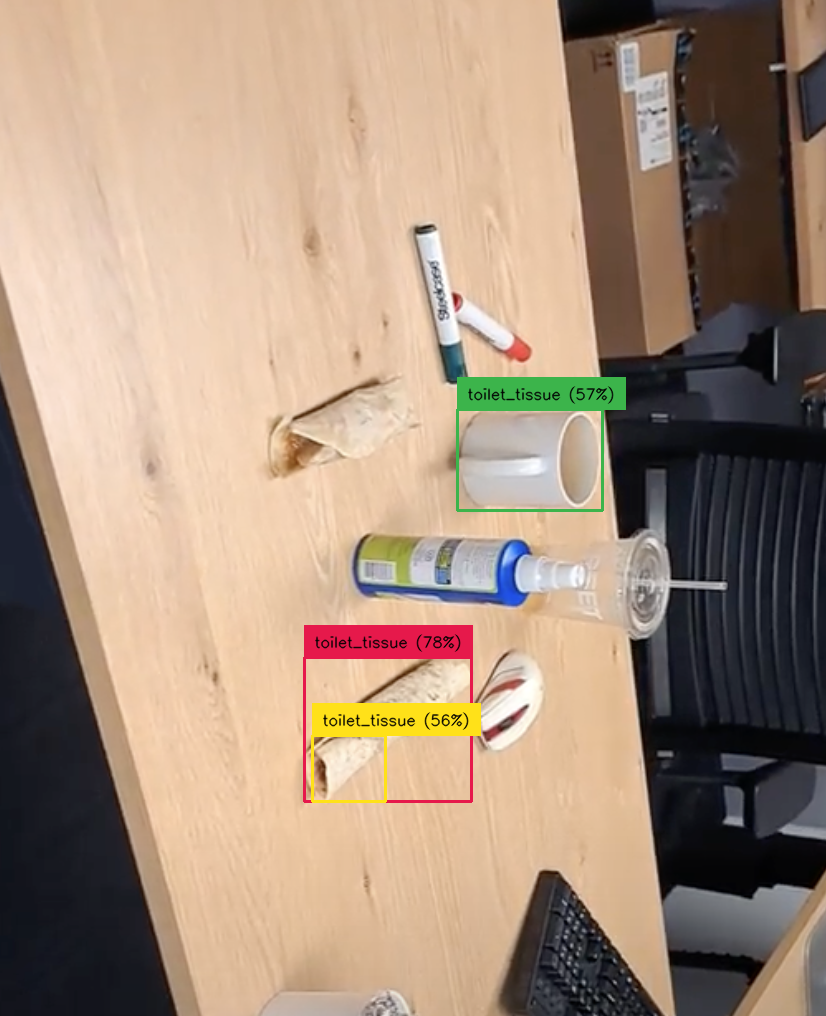

In [ ]:
outputs = query.detect(clsf, conf_threshold=0.01)

detections = sv.Detections(xyxy=outputs['instances'].pred_boxes.tensor.cpu().numpy())
scores = outputs['instances'].scores
labels = classes[outputs['instances'].pred_classes.int().cpu().numpy()]
labels = [f'{l} ({s:.0%})' for l, s in zip(labels, scores)]
print(labels)
source_image = box_annotator.annotate(scene=rgb[:,:,::-1].copy(), detections=detections, labels=labels)[:,:,::-1]
Image.fromarray(source_image)